In [274]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import time

In [275]:
def get_image_info(image):
    height = image.shape[0]
    width = image.shape[1]
    num_channels = image.shape[-1] if image.ndim != 2 else 1
    return height, width, num_channels

In [276]:
def change_brightness(image, alpha=5, gamma=0.5):
    # Balanced color
    balanced_image = np.empty_like(image, dtype=np.float32)
    balanced_image = 255 * (image / 255) ** gamma
    new_image = np.clip(balanced_image + alpha, 0, 255)
    
    return new_image.astype(np.uint8)

In [277]:
def change_contrast(image, alpha = 1.5):
    new_image = np.empty_like(image, dtype=np.float32)
    new_image = np.clip(image * alpha, 0, 255)

    return new_image.astype(np.uint8)

In [278]:
def rotate_image(image, rotate_type='vertical'):
    if rotate_type == 'vertical':
        new_image = np.array(image[:,::-1])
    elif rotate_type == 'horizontal':
        new_image = np.array(image[::-1])
    return new_image

In [279]:
def slicing_color_channel(image):
    _, _, num_channels = get_image_info(image)
    color_channels = [image[:, :, i] for i in range(num_channels)]

    return color_channels

In [280]:
def convert_RGB_to_grayscale(image):
    color_channels = slicing_color_channel(image)
    new_image = np.stack((color_channels[0] * 0.3 + color_channels[1] * 0.59 + color_channels[2] * 0.11), dtype=np.float32)
    new_image = np.clip(new_image, 0, 255)
    
    return new_image.astype(np.uint8)
    

In [281]:
def convert_RGB_to_Sepia(image):
    color_channels = slicing_color_channel(image)

    tr = np.clip(0.393 * color_channels[0] + 0.769 * color_channels[1] + 0.189 * color_channels[2], 0, 255)
    tg = np.clip(0.349 * color_channels[0] + 0.686 * color_channels[1] + 0.168 * color_channels[2], 0, 255)
    tb = np.clip(0.272 * color_channels[0] + 0.534 * color_channels[1] + 0.131 * color_channels[2], 0, 255)

    new_image = np.stack((tr, tg, tb), axis=2)
    
    return new_image.astype(np.uint8)

In [282]:
def guassian(x, y, sigma):
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

    return kernel / np.sum(kernel)


In [283]:
def convolve_channel(channels, kernel):
    result = []
    add = 1 if kernel.shape[0] % 2 != 0 else 0
    
    sub_shape = kernel.shape + tuple(np.subtract(channels[0].shape, kernel.shape) + add)
    for i in range(len(channels)):
        strd = np.lib.stride_tricks.as_strided
        subM = strd(channels[i], shape=sub_shape, strides=channels[i].strides * 2)
        result.append(np.einsum('ij, ijkl->kl', kernel, subM))
    
    return result

In [284]:
def convolve2D(image, kernel):
    kernel_size = kernel.shape[0]
    padding = kernel_size // 2 

    # If image is grayscale (2D) convert to 3D 
    _, _, num_channels = get_image_info(image)
    if num_channels == 1:
        image = image.reshape(image.shape[0], image.shape[1], 1)
    
    # Add padding to image for convolution
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='reflect')
    # Slice image into color channels
    color_channels = slicing_color_channel(padded_image)
    # Convolve each color channel
    convolved_channels = convolve_channel(color_channels, kernel)
    # Stack color channels back into image
    new_image = np.stack(convolved_channels, axis=-1)
    
    # Convert back to 2D if image was originally grayscale
    if num_channels == 1:
        new_image = new_image.reshape(new_image.shape[0], new_image.shape[1])

    return new_image.astype(np.uint8)
    

In [285]:
def blur_image(image, kernel_size = 10, sigma = 5):
    image = image.astype(np.float32)
    x, y = np.meshgrid(np.linspace(- kernel_size // 2, kernel_size // 2, kernel_size), np.linspace(- kernel_size // 2, kernel_size // 2, kernel_size))
    
    # Calculate the 2-D gaussian kernel
    kernel = guassian(x, y, sigma)
    # Blur image by convolving the gaussian kernel with the image
    blur_image = convolve2D(image, kernel)
    # Clip the image to be between 0 and 255
    blur_image = np.clip(blur_image, 0, 255)

    return blur_image.astype(np.uint8)

def sharpen_image(image, kernel_size = 10, sigma = 5):
    # Blur the image to get the low frequency component
    blurred_image = blur_image(image, kernel_size, sigma)
    blurred_image = blurred_image.astype(np.float32)
    # Subtract the low frequency component from the original image to get the high frequency component
    sharpen_image = image - blurred_image + image
    # Clip the image to be between 0 and 255
    sharpen_image = np.clip(sharpen_image, 0, 255)
    
    return sharpen_image.astype(np.uint8)


In [286]:
def cut_center(image, width, height, size):
    center = min(height // 2, width // 2)

    size = center if size // 2 > center else size

    lower_bound = center - size // 2
    upper_bound = center + size // 2 + 1

    new_image = image[lower_bound : upper_bound, lower_bound : upper_bound]
    
    return new_image

def circular_mask(width, height):
    center = min(width//2, height//2)
    # create a mask first
    y, x = np.ogrid[:width, :height]
    # then compute the center and radius of the circle
    mask = (x - height//2)**2 + (y - width//2)**2 <= (center)**2

    return mask

def cut_circle(image, width, height):
    # create a mask first
    mask = circular_mask(width, height)

    result = np.zeros_like(image)
    # copy the image to the result array using the mask
    result[mask] = image[mask]

    return result



In [287]:
def solve_equation(point1, point2, alpha=45):
    angle_radian = np.deg2rad(alpha)

    f1_sum = point1[0] * np.cos(angle_radian) + point1[1] * np.sin(angle_radian)
    f1_sub = point1[0] * np.cos(angle_radian) - point1[1] * np.sin(angle_radian)

    f2_sum = point2[0] * np.cos(angle_radian) + point2[1] * np.sin(angle_radian)
    f2_sub = point2[0] * np.cos(angle_radian) - point2[1] * np.sin(angle_radian)
 
    A = f1_sum**2 if point1[0] == point1[1] else f2_sum**2
    B = (f1_sub**2 - f2_sub**2) * A / (f2_sum**2 - f1_sum**2)

    return A, B

In [288]:
def ellipse_mask(width, height, A, B, alpha=45):
    y, x = np.ogrid[:height, :width]
    angle = np.deg2rad(alpha)

    rotate_x = (x - width // 2) * np.cos(angle) - (y - height // 2) * np.sin(angle)
    rotate_y = (x - width // 2) * np.cos(angle) + (y - height // 2) * np.sin(angle)

    mask = rotate_x ** 2 / B + rotate_y ** 2 / A <= 1.0
    
    return mask


def cut_ellipse(image, width, height):
    alpha = 45
    edge = min(height, width)
    point1 = [edge // 4, edge // 4]
    point2 = [edge // 2, -edge // 4]

    A, B = solve_equation(point1, point2, alpha)
    
    result = np.zeros_like(image)

    mask1 = ellipse_mask(width, height, A, B, alpha)
    mask2 = ellipse_mask(width, height, A, B, -alpha)

    result[mask1] = image[mask1]
    result[mask2] = image[mask2]

    return result

    

In [289]:
def read_image(img_name):
    # Read and convert to numpy.array
    image = PIL.Image.open(img_name)
    image = np.array(image)
    return image

In [290]:
def save_image(image, name, captions, mode):
    sep = name.find('.')
    subName = name[:sep]
    format = name[sep:]

    for i, img in enumerate(image):
        if mode == 0:
            img_name = f'{subName}_{captions[i+1].lower()}{format}'
        else:
            img_name = f'{subName}_{captions[mode].lower()}{format}'
        save_image = PIL.Image.fromarray(img)
        save_image.save(img_name)

In [291]:
def show_image(images, new_images, captions, runtime, mode):
    num_images = len(new_images) + 1  

    if mode != 0:
        num_rows = 1
    else:
        num_rows = (num_images + 3) // 4  
    # If there are less than 4 images, take num_cols = num_images
    num_cols = min(num_images, 4)  

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    axs = axs.ravel()
    # Show the original image first
    axs[0].imshow(images)
    axs[0].set_title(captions[0])

    for i, img in enumerate(new_images):
        if i == 4 or mode == 5:
            axs[i+1].imshow(img, cmap='gray')
        else:
            axs[i+1].imshow(img)

        if mode != 0:
            title = f'{captions[mode]} - {runtime[0]} ms'
        else:
            title = f'{captions[i+1]} - {runtime[i]} ms'

        axs[i+1].set_title(title)


In [292]:
def set_captions():
    captions = {
        0 : "Original",
        1 : "Adjust_brightness", 
        2 : "Adjust_contrast",
        3 : "Rotate-vertical",
        4 : "Rotate-horizontal",
        5 : "Grayscale",
        6 : "Sepia",
        7 : "Blur",
        8 : "Sharpen",
        9 : "Cut_center",
        10 : "Cut_circle",
        11 : "Cut_ellipse"
    }
    
    return captions

In [293]:
def exec_mode(image, width, height, mode, num_channels):
    operations = [
        (change_brightness, {'alpha': 50, 'gamma': 1.2}),
        (change_contrast, {'alpha': 1.3}),
        (rotate_image, {'rotate_type': 'vertical'}),
        (rotate_image, {'rotate_type': 'horizontal'}),
        (convert_RGB_to_grayscale, {}),
        (convert_RGB_to_Sepia, {}),
        (blur_image, {'kernel_size' : 5, 'sigma': 5}),
        (sharpen_image,  {'kernel_size' : 5, 'sigma': 5}),
        (cut_center, {'width': width, 'height': height, 'size': 256}),
        (cut_circle, {'width': width, 'height': height}),
        (cut_ellipse, {'width': width, 'height': height})
    ]
    
    result = []
    runtime = []

    if mode == 0:
        for operation, kwargs in operations:
            start_time = time.time()
            result.append(operation(image, **kwargs))
            end_time = time.time()

            exec_time = (end_time - start_time) * 1000
            runtime.append(round(exec_time))

    elif 1 <= mode <= len(operations):
        operation, kwargs = operations[mode - 1]

        start_time = time.time()
        result.append(operation(image, **kwargs))
        end_time = time.time()

        exec_time = (end_time - start_time) * 1000
        runtime.append(round(exec_time))

    return result, runtime

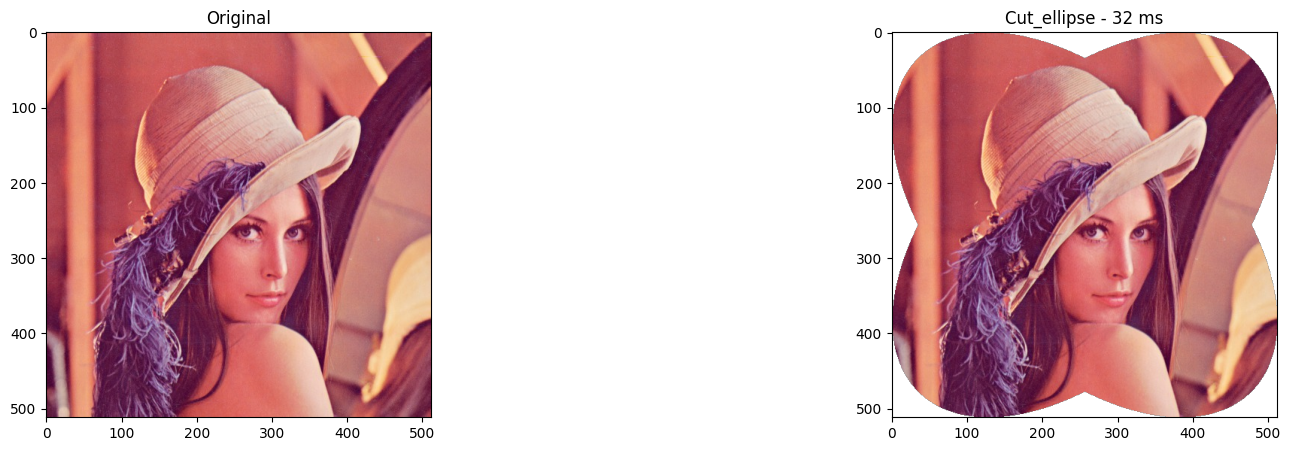

In [294]:
def main():
    img_name = input('Enter image name: ')
    mode = input('Enter mode: ')
    mode = int(mode)
    # Get image and info
    image = read_image(img_name)

    captions = set_captions()
 
    height, width, num_channel = get_image_info(image)

    new_image, runtime = exec_mode(image, width, height, mode, num_channel)

    show_image(image, new_image, captions=captions, runtime=runtime ,mode=mode)
    save_image(new_image, img_name, captions=captions, mode=mode)

if __name__ == "__main__":
    main()